# Predicting survivors on Titanic

## Dependencies

In [62]:
# Import Dependencies
%matplotlib inline

from importlib import reload

# Start Python Imports
import math, time, random, datetime

# Data Manipulation
import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype

# Data Imputation
import datawig
from impyute.imputation.cs import mice

# Feature Selection
from genetic_selection import GeneticSelectionCV

# Visualization 
import matplotlib.pyplot as plt
import missingno
import seaborn as sns

# Classifiers
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import (cross_val_score, cross_val_predict, train_test_split, cross_validate,
                                     StratifiedKFold)
from sklearn.svm import LinearSVC
from sklearn.ensemble import (GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier, 
                              ExtraTreesClassifier)
from sklearn.experimental import enable_iterative_imputer
from sklearn.feature_selection import RFE, RFECV, chi2, f_classif, mutual_info_classif
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier, BayesianRidge
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV

plt.style.use('seaborn-whitegrid')

## Information from the problem description

* There were 2224 people aboard, out of which 1502 died.
* The massive loss of life is mostly due to lack of lifeboats on the ship.
* Although there was some element of luck involved in surviving the sinking, some groups of people were more likely to survive than others, such as women, children, and the upper-class.

## Loading the data

In [3]:
# Import train & test data 
train = pd.read_csv('data/train.csv', index_col='PassengerId')
test = pd.read_csv('data/test.csv')
gender_submission = pd.read_csv('data/gender_submission.csv') # example of what a submission should look like

In [4]:
train.head(15)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S


**Survival:** 0 = No, 1 = Yes

**pclass (Ticket class):** 1 = 1st, 2 = 2nd, 3 = 3rd

**sex:** Sex

**Age:** Age in years

**sibsp:** number of siblings/spouses aboard the Titanic

**parch:** number of parents/children aboard the Titanic

**ticket:** Ticket number

**fare:** Passenger fare

**cabin:** Cabin number

**embarked:** Port of Embarkation, C = Cherbourg, Q = Queenstown, S = Southampton

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Name        891 non-null object
Sex         891 non-null object
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Ticket      891 non-null object
Fare        891 non-null float64
Cabin       204 non-null object
Embarked    889 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [6]:
# We will progressively copy the training dataframe into separate dataframes
# since it is proferrable to not modify the original dataset in this case
df_train = train.copy()
df_train['Male'] = np.where(df_train['Sex'] == 'male', 1, 0).astype('bool') # Since sex is initially string, make it into a category
df_train = df_train.drop('Sex', axis=1)
df_train['Survived'] = df_train['Survived'].astype('bool')
df_train['Pclass'] = df_train['Pclass'].astype(CategoricalDtype(ordered=True))

## Feature engineering

### Title from name

Looking at the names, we quickly realize that all passengers have titles. It may be the case that passengers with very rare titles were prioritized over regular passangers, so we extract the the title as a separate feature. On the other hand, we have to be careful, since there are numerous titles and we don't want to introduce too many categorical features - it is necessary to group the titles sensibly.

Ideas:
* An average male doctor may have been more likely to survive than an average male.
* Military and religious titles may have been more likely to die.
* Female nobility may have been more likely to survive

-> group into (Miliary, Religious, Regular, Doctors)?

Let's start by grouping identical titles and simply introducing 'other' category.


In [7]:
# Get titles from names
def get_title(name, filt=False, male=None):
    title = list(filter(lambda x: '.' in x, name.split(' ')))[0]
    return filter_title(title, male) if filt else title

def filter_title(title, male):
    # Replace superfluous titles
    if title in ('Mlle.', 'Ms.', 'Miss.') :
        title = 'Miss.'
    elif title == 'Mme.':
        title = 'Mrs.'
    elif title in other:
        title = 'Other_m' if male else 'Other_f'
    return title

titles = np.array([get_title(name) for name in train.Name])

# Do all people have titles?
print('All passangers have titles:', len(titles) == len(train))
print(pd.value_counts(titles))

All passangers have titles: True
Mr.          517
Miss.        182
Mrs.         125
Master.       40
Dr.            7
Rev.           6
Mlle.          2
Col.           2
Major.         2
Sir.           1
Lady.          1
Jonkheer.      1
Ms.            1
Mme.           1
Don.           1
Countess.      1
Capt.          1
dtype: int64


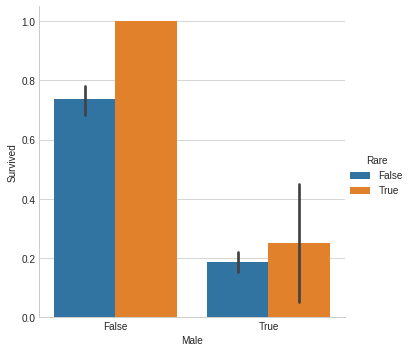

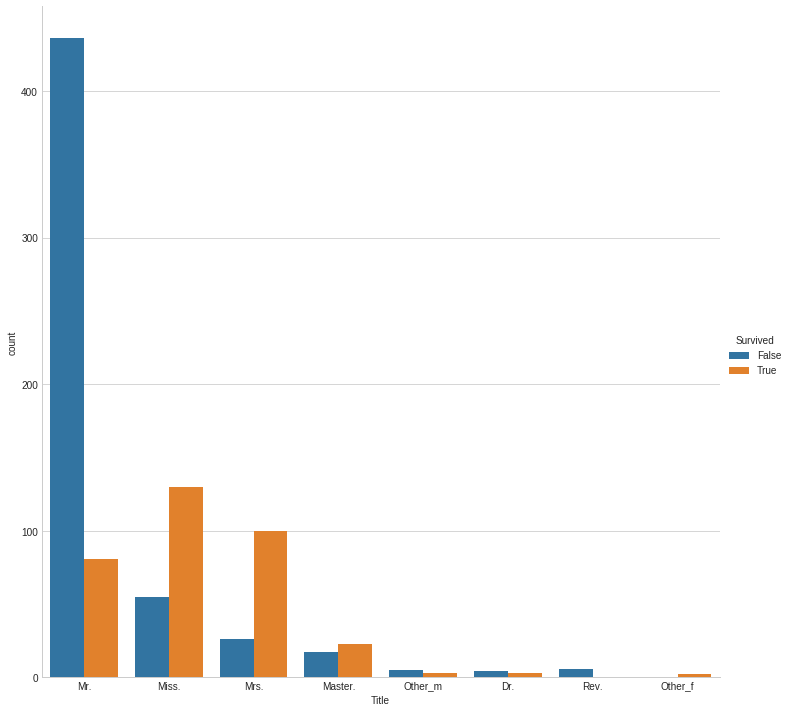

In [8]:
# Add titles and rarity as nominal features
rare = [title for title, count in zip(*np.unique(titles, return_counts=True)) if count < 40]
# We will group the rarest titles into 'other' group 
other = [title for title, count in zip(*np.unique(titles, return_counts=True)) if count < 3]

df_train['Title'] = df_train.apply(lambda r: get_title(r.Name, filt=False), axis=1).astype(CategoricalDtype(ordered=False))
df_train['Rare'] = df_train.apply(lambda r: int(r.Title in rare+other), axis=1).astype('bool')
df_train['Title'] = df_train.apply(lambda r: get_title(r.Name, filt=True, male=r.Male), axis=1).astype(CategoricalDtype(ordered=False))
df_train['Master'] = df_train.apply(lambda r: int(r.Title =='Master.'), axis=1).astype('bool')
df_train['Mr'] = df_train.apply(lambda r: int(r.Title == 'Mr.'), axis=1).astype('bool')

sns.catplot(data=df_train, x='Male', y='Survived', hue='Rare', kind='bar')
sns.catplot(data=df_train, x='Title', hue='Survived', kind='count', order=df_train.Title.value_counts().index, height=10)

Observations:
* Bearers of rare titles indeed do seem to be more likely to survive.
* Miss. and Mrs. have about the same rate of survival
* Master. have much higher rate of survival than regular Mr.

### Deck from cabin

There are too many unique values for cabin to consider it as a categorical feature, but we may extract the first letter, which happens to to be the deck where the cabin is located and hence is more coarse. Then, it will be easier to fill in the missing values.

In [9]:
train.Cabin.value_counts()[train.Cabin.value_counts() == 1].index.values

array(['C118', 'B4', 'E49', 'F E69', 'D37', 'C128', 'E68', 'B50', 'D47',
       'D48', 'E77', 'D21', 'A16', 'E12', 'F G63', 'C45', 'D9', 'C106',
       'C110', 'A31', 'B19', 'B71', 'B86', 'E63', 'C50', 'B39', 'B30',
       'B38', 'C87', 'A19', 'C111', 'E46', 'B102', 'D10 D12', 'E36',
       'A26', 'C30', 'C46', 'D56', 'C101', 'B94', 'C86', 'B80', 'C49',
       'A5', 'D11', 'D49', 'B101', 'C54', 'E40', 'D50', 'C104', 'D7',
       'D15', 'F38', 'C47', 'E38', 'A14', 'C95', 'D30', 'C62 C64', 'E34',
       'C7', 'A10', 'D6', 'E31', 'B82 B84', 'C99', 'E50', 'B42', 'D46',
       'A20', 'A32', 'B73', 'C82', 'A24', 'C70', 'D19', 'B3', 'C85',
       'B78', 'A6', 'C32', 'E10', 'B69', 'C148', 'A7', 'C91', 'A23',
       'D45', 'T', 'B79', 'B37', 'C103', 'B41', 'A36', 'D28', 'C90',
       'A34', 'E17', 'E58'], dtype=object)

In [10]:
train[train.Cabin == 'G6']

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
11,1,3,"Sandstrom, Miss. Marguerite Rut",female,4.0,1,1,PP 9549,16.7000,G6,S
206,0,3,"Strom, Miss. Telma Matilda",female,2.0,0,1,347054,10.4625,G6,S
252,0,3,"Strom, Mrs. Wilhelm (Elna Matilda Persson)",female,29.0,1,1,347054,10.4625,G6,S
395,1,3,"Sandstrom, Mrs. Hjalmar (Agnes Charlotta Bengt...",female,24.0,0,2,PP 9549,16.7000,G6,S


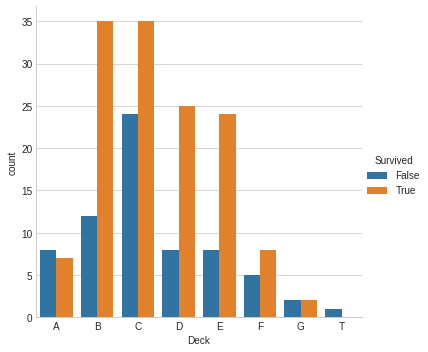

In [11]:
def get_deck(row):
    if row.Cabin is np.NaN:
        return np.NaN
    return str(row.Cabin)[0]

df_train['Deck'] = df_train.apply(lambda r: get_deck(r), axis=1).astype(CategoricalDtype(ordered=False))
sns.catplot(data=df_train, x='Deck', hue='Survived', kind='count')

Observations:
* When a group (e.g. family) registered multiple cabins, each passenger seems to have all of the cabins assigned.
* However, some groups have less cabins assigned than the number of persons in group - maybe we can find persons who they are related to and assign them to the same cabin (e.g. based on name). On the other hand, this may be unreliable and just add noise.
* It seems that the lower class sometimes registered multiple persons to a single cabin. Maybe we can quantify that? However, it is questionable how much predctive power such information has.
* Passengers in cabin A seem slightly more likely to surive (T may be just fluctuation). 

Decisions:
* Do not add deck as a feature.

### Family size

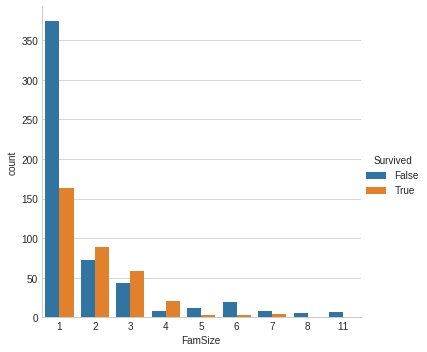

In [12]:
df_train['FamSize'] = train.apply(lambda r: r.SibSp + r.Parch + 1, axis=1)
sns.catplot(data=df_train, x='FamSize', hue='Survived', kind='count')

In [13]:
def get_fam_size(row):
    if row.FamSize == 1 or row.FamSize > 4:
        return 0
    else:
        return 1
    
df_train['FamSize'] = df_train.apply(lambda r: get_fam_size(r), axis=1).astype(CategoricalDtype(ordered=True))

Observation:
* People travelling in families were more likely to survive for family size 2, 3, 4 (and progressively so). However, for more numerous families, the trend reverses.

Decision:
* Add family size either as a categorical (3 categories) or numerical feature for the classifier.

### Mother, father, child, loners, 3rd class

We want to distinguish parents and children. In particular, difference between mothers and fathers may have been important. 

In [14]:
def is_mother(row):
    return row.Age >= 18 and row.Parch > 0 and row.Male == False and row.Title != 'Miss.'
def is_father(row):
    return row.Age >= 18 and row.Parch > 0 and row.Male == True
def is_child(row):
    return row.Age < 18 and row.Parch > 0
def is_alone(row):
    return row.FamSize == 1 
def is_3rd_class(row):
    return row.Pclass == 3

df_train['Mother'] = df_train.apply(lambda r: is_mother(r), axis=1).astype('bool')
df_train['Father'] = df_train.apply(lambda r: is_father(r), axis=1).astype('bool')
df_train['Child'] = df_train.apply(lambda r: is_child(r), axis=1).astype('bool')
df_train['Alone'] = df_train.apply(lambda r: is_alone(r), axis=1).astype('bool')
df_train['Class3'] = df_train.apply(lambda r: is_3rd_class(r), axis=1).astype('bool')

In [15]:
for _, g in train.groupby("Name"):
    if len(g) > 1:
        print(g)

Observation:
* There seem to be no duplicated names.
* There are duplicated cabins, but that seems to be because cabins are assigned group-wise and multiple people may share the same deck.

## Data imputation

### Missing values

Survived      0
Pclass        0
Name          0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
Male          0
Title         0
Rare          0
Master        0
Mr            0
Deck        687
FamSize       0
Mother        0
Father        0
Child         0
Alone         0
Class3        0
dtype: int64


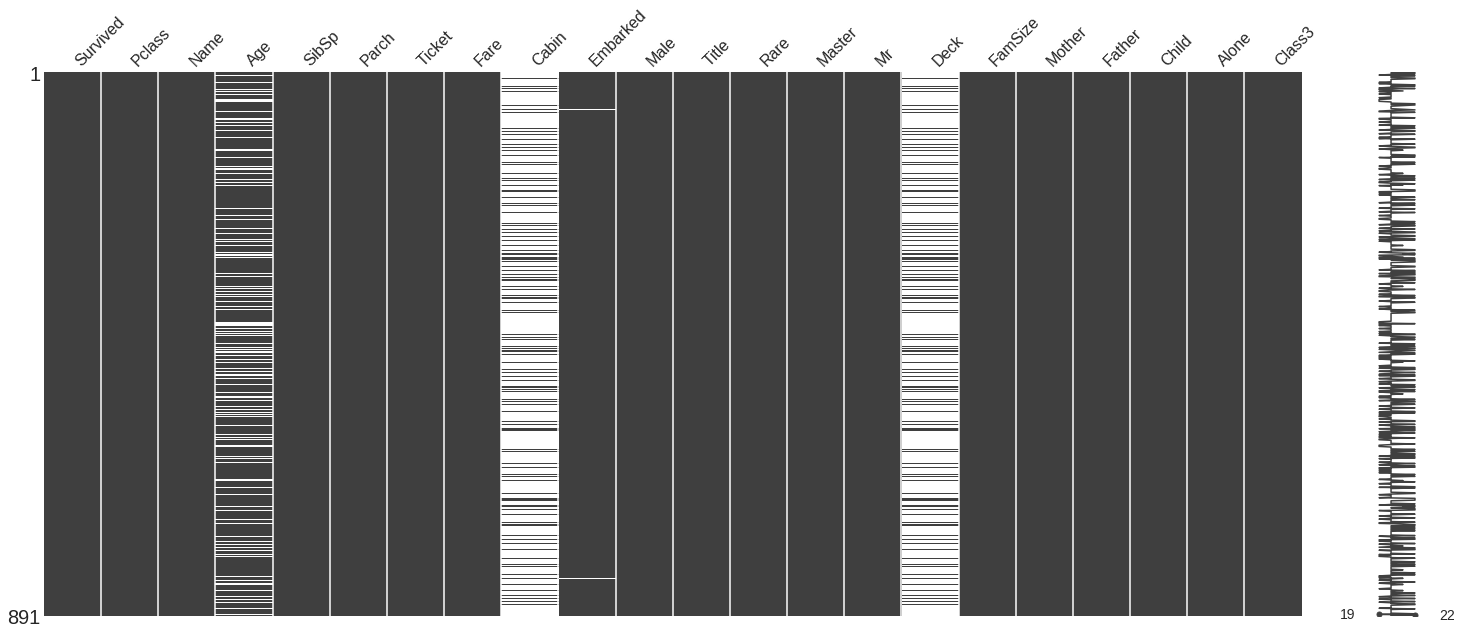

In [16]:
print(df_train.isnull().sum())
missingno.matrix(df_train)

Observations:
* Age has almost 20% missing values
* Cabin has 77% missing values
* There are 2 missing values in Embarked. It may be possible to infer them from class and ticket price.

Decisions:
* We may need to have to fill cabin from other sources, or drop it. We will check if its correlated with survival.
* Age will likely have to be filled in, since it is correlated with survival according to the description.
* We may also drop PassengerId, since it is definitely no related to survival.
* Try to impute missing Embarked.

### Imputing missing embarkation

In [17]:
df_train[df_train.Embarked.isnull()]

,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,...,Rare,Master,Mr,Deck,FamSize,Mother,Father,Child,Alone,Class3
PassengerId,,,,,,,,,,,,,,,,,,,,,
62,True,1,"Icard, Miss. Amelie",38.0,0,0,113572,80.0,B28,NaN,...,False,False,False,B,0,False,False,False,False,False
830,True,1,"Stone, Mrs. George Nelson (Martha Evelyn)",62.0,0,0,113572,80.0,B28,NaN,...,False,False,False,B,0,False,False,False,False,False


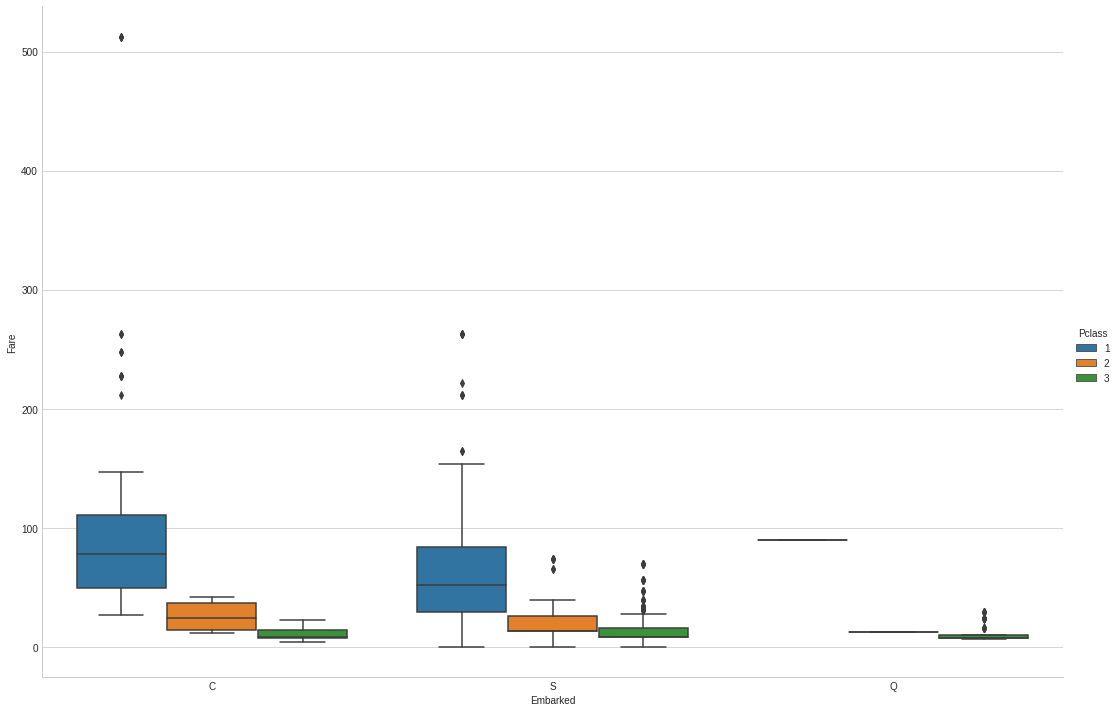

In [18]:
# Plot relationship between Fare, class, and embarked
sns.catplot(
    x='Embarked', y='Fare', hue='Pclass', kind='box', data=train, order=['C', 'S', 'Q'], height= 10, aspect=1.5)

In [19]:
df_train.loc[62, 'Embarked'] = 'S'
df_train.loc[830, 'Embarked'] = 'S'
df_train['Embarked'] = df_train['Embarked'].astype(CategoricalDtype(categories=['S', 'C', 'Q'], ordered=False))

Observation:
* Median fare for port S corresponds to 80 USD paid by the passengers.

Assumption:
* They embarked from port S.

Decision:
* Impute missing port of embarkation.

### Imputing missing age

#### Datawig

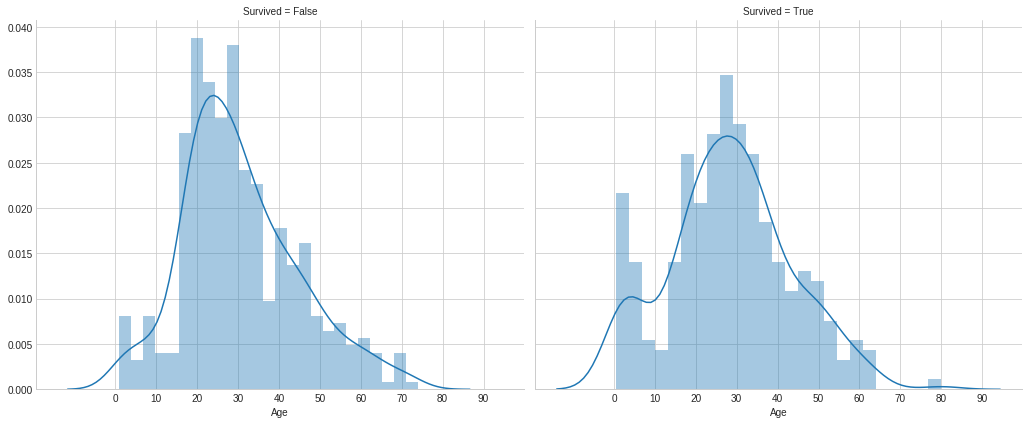

In [20]:
g = sns.FacetGrid(df_train, col='Survived', height=6, aspect=1.2)
g.set(xticks=np.arange(0,len(df_train),10))
g.map(sns.distplot, 'Age', bins=25)

Observation:
* It seems children aged < 5 were much more likely to survive.

Decision:
* Categorize age, put children aged < 5 into a separate category.

In [21]:
df_train.columns

Index(['Survived', 'Pclass', 'Name', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare',
       'Cabin', 'Embarked', 'Male', 'Title', 'Rare', 'Master', 'Mr', 'Deck',
       'FamSize', 'Mother', 'Father', 'Child', 'Alone', 'Class3'],
      dtype='object')

In [22]:
def fit_wo_logging(train_df, num_epochs, imputer):
    import logging
    logging.disable(logging.WARNING)
    imputer.fit(train_df=train_df, num_epochs=num_epochs)
    logging.disable(logging.NOTSET)
    return imputer
    
def cut(df, start=0, end=81, bins_step=5):
    return pd.cut(df, bins=np.arange(start, end, bins_step))

def evaluate(pred, act, bins_step=5):
    # Get test set accuracy
    imp = pd.concat([pred, act], axis=1).dropna()
    pred = cut(imp.iloc[:, 0])
    act = cut(imp.iloc[:, 1])
    return (pred == act).sum() / len(pred)

def train_dtwg(
    df_train=df_train,
    input_columns=[c for c in df_train.columns if c not in ('Name', 'Cabin', 'Ticket')],
    test_size=0.2,
    num_epochs=100
    ):
    
    df_dtwg = pd.get_dummies(df_train[input_columns])

    df_dtwg_train, df_dtwg_test = datawig.utils.random_split(df_dtwg, split_ratios=[1-test_size, test_size])

    # Initialize a SimpleImputer model
    imputer = datawig.SimpleImputer(
        input_columns=df_dtwg.columns, # column(s) containing information about the column we want to impute
        output_column= 'Age', # the column we'd like to impute values for
        # output_path = 'imputer_model' # stores model data and metrics
    )

    # Fit an imputer model on the train data
    imputer = fit_wo_logging(df_dtwg_train, num_epochs, imputer)
    
    acc = None
    if test_size > 0.0:
        # Impute missing values and return original dataframe with predictions
        pred = imputer.predict(df_dtwg_test)
        acc = evaluate(pred['Age_imputed'], pred['Age'])
        print('Accuracy', acc)
        
    return imputer, acc


accuracies = []
k = 5
for i in range(k):
    _, acc = train_dtwg()
    accuracies.append(acc)
print('Averaged accuracy over {} iterations:'.format(k), np.mean(accuracies))

Accuracy 0.7891156462585034
Accuracy 0.8707482993197279
Accuracy 0.782312925170068
Accuracy 0.7414965986394558
Accuracy 0.8367346938775511
Averaged accuracy over 5 iterations: 0.8040816326530612


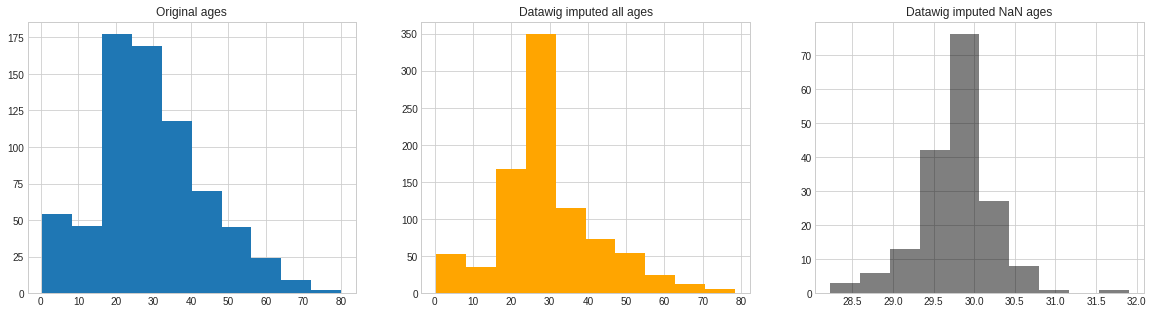

In [23]:
imputer, _ = train_dtwg(df_train, test_size=0.0)

# Plot histogram of imputed ages
dtwg_imp = imputer.predict(pd.get_dummies(df_train))[['Age_imputed']]

# Compare original and imputed distributions of age
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
ax[0].hist(df_train['Age'].dropna())
ax[0].set_title('Original ages')
ax[1].hist(dtwg_imp.values, facecolor='orange')
ax[1].set_title('Datawig imputed all ages')
missing = df_train['Age'].isnull()
ax[2].hist(dtwg_imp[missing].values, facecolor='black', alpha=0.5)
ax[2].set_title('Datawig imputed NaN ages')
plt.show()

Observations:
* Using bins of size 10, we are achieving over 90% accuracy on the test set.
* However, it is quite worrysome that most of the imputed values lie in range 28.5 to 33.

Decisions:
* Do not use age values using  for the age.
* We have to find another way to impute data.

Note:
* It may be preferrable to categorize the data before training, but Datawig does not seem to work well with categorical data.

#### MICE

In [24]:
def train_mice(df_train=df_train, test_size=0.0):
    # Start the MICE training
    dummified = pd.get_dummies(df_train).applymap(float)
    df_mice_train, df_mice_test = \
        train_test_split(dummified, test_size=test_size) if test_size else dummified, None
    imp_train = mice(df_mice_train)
    imp_train.index = df_mice_train.index
    imp_train.columns = df_mice_train.columns 
    if test_size > 0.0:
        # The library currently does not support saving model and predicting
        pass
    return imp_train

In [25]:
df_train.columns

Index(['Survived', 'Pclass', 'Name', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare',
       'Cabin', 'Embarked', 'Male', 'Title', 'Rare', 'Master', 'Mr', 'Deck',
       'FamSize', 'Mother', 'Father', 'Child', 'Alone', 'Class3'],
      dtype='object')

/home/miroslav/.local/share/virtualenvs/ds_projects-Req6_Qpc/lib/python3.5/site-packages/impyute/util/preprocess.py:52: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  args[0] = args[0].as_matrix()
/home/miroslav/.local/share/virtualenvs/ds_projects-Req6_Qpc/lib/python3.5/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


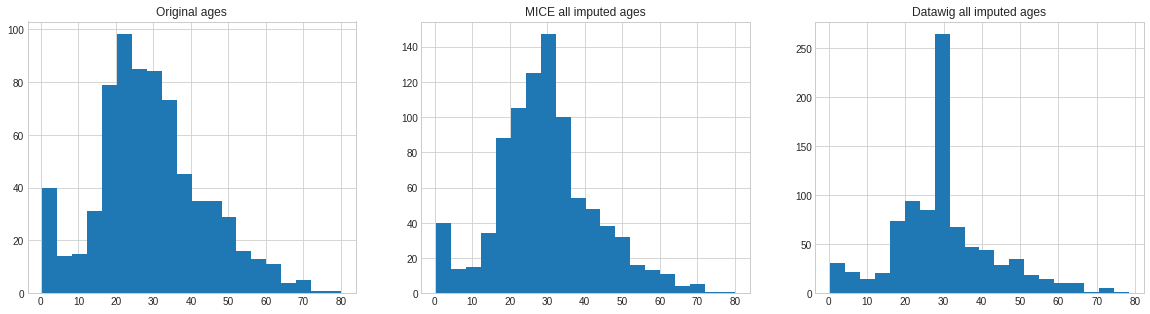

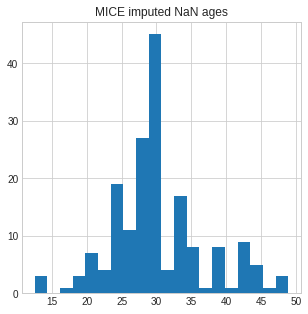

In [26]:
input_columns = [c for c in df_train.columns if c not in ('Name', 'Ticket', 'Cabin')]

mice_imp = train_mice(df_train[input_columns], test_size=0.0)['Age']
mice_imp[mice_imp <= 0] = 1

fig, ax = plt.subplots(1, 3, figsize=(20, 5))
bins = 20
ax[0].hist(df_train['Age'].dropna(), bins=bins)
ax[0].set_title('Original ages')
ax[1].hist(mice_imp, bins=bins)
ax[1].set_title('MICE all imputed ages')
ax[2].hist(dtwg_imp.values, bins=bins)
ax[2].set_title('Datawig all imputed ages')
fig.show()

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
missing = df_train['Age'].isnull()
ax.hist(mice_imp[missing].values, bins=bins)
ax.set_title('MICE imputed NaN ages')
fig.show()

In [27]:
# Impute missing values to age column
df_train.loc[missing, 'Age'] = mice_imp[missing]

In [28]:
def priority(row):
    # TODO: Factor in Sex, maybe fare
    return row.Pclass * row.Age

# With missing ages, we can create simple 'priority' feature
df_train['Priority'] = df_train.apply(lambda r: priority(r), axis=1)

### Imputing missing deck

We will encode the cabin as an ordinal and use the most frequent The following probably isn't entirely proper way of imputing categorical values.

In [29]:
def factorize_categorical(df):
    df_c = df.copy()
    for col in df_c.select_dtypes('category').columns:
        df_c[col] = pd.factorize(df_c[col], na_sentinel=-1)[0]
        df_c.loc[df_c[col] == -1, col] = np.NaN
    return df_c

imp = IterativeImputer(estimator=BayesianRidge(), max_iter=10, random_state=0,
                       initial_strategy='most_frequent', min_value=0, max_value=7)
df_train_temp = factorize_categorical(df_train)
df_train_temp = imp.fit_transform(df_train_temp[input_columns])  
df_train_temp = pd.DataFrame(df_train_temp, columns=input_columns, index=np.arange(1, 892))
df_train_temp.Deck = df_train_temp.Deck.round()
df_train.Deck = df_train_temp.Deck.astype('category')

## Feature selection

In [30]:
def compute_stats(X, y, stat, cols):
    s, pval = stat(X, y)
    for col_name, c, p in sorted(zip(cols, s, pval), key=lambda t: t[2]):
        print('{:<20} {:<8.3f} {:<8.3f}'.format(col_name, c, p)) 
        
input_columns = [
    c for c in df_train.columns if c not in (
        'Name', 'Ticket', 'Cabin', 'Survived', 'Deck')
        # 'Embarked', 'Title', 'Father', 'Pclass', 'SibSp', 'Parch', 'Rare', 'Master', 'Child')
        # 'Title', 'FamSize', 'Mother', 'Father', 'Child', 'Alone', 'Rare', 'Priority', 'Deck')
]

# Make sure we have no NaNs
# print(df_train[input_columns].isnull().sum())

# Decide whether to factorize or dummify categorical variables
df_train_dummies = pd.get_dummies(df_train[input_columns])
# df_train_dummies = factorize_categorical(df_train[input_columns])

X_train = df_train_dummies.values
y_train = df_train.Survived

cv=StratifiedKFold(n_splits=10, shuffle=False, random_state=1)

print(df_train_dummies.columns)

Index(['Age', 'SibSp', 'Parch', 'Fare', 'Male', 'Rare', 'Master', 'Mr',
       'Mother', 'Father', 'Child', 'Alone', 'Class3', 'Priority', 'Pclass_1',
       'Pclass_2', 'Pclass_3', 'Embarked_S', 'Embarked_C', 'Embarked_Q',
       'Title_Dr.', 'Title_Master.', 'Title_Miss.', 'Title_Mr.', 'Title_Mrs.',
       'Title_Other_f', 'Title_Other_m', 'Title_Rev.', 'FamSize_0',
       'FamSize_1'],
      dtype='object')


### RFE

Optimal number of features : 20


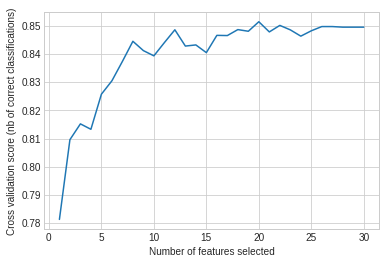

The only features NOT selected: Master, Mother, Child, Alone, Pclass_1, Pclass_2, Title_Dr., Title_Miss., Title_Other_f, FamSize_1


In [31]:
gb = GradientBoostingClassifier()
rfecv = RFECV(gb, step=1, min_features_to_select=1, scoring='f1_weighted', cv=cv)
rfecv.fit(X_train, y_train)

print("Optimal number of features : %d" % rfecv.n_features_)

plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

print('The only features NOT selected: %s' % ', '.join(df_train_dummies.columns[~rfecv.get_support()]))

### Genetic algorithm

In [32]:
# Genetic algorithm is quite computationally demanding

# gscv = GeneticSelectionCV(gb, cv=cv)
# gscv.fit(X_train, y_train)

# print('Selected features: %s' % ', '.join(df_train_dummies.columns[gscv.get_support()]))

### Other

In [33]:
compute_stats(X_train, y_train, chi2, df_train_dummies.columns)
print('-'*36)
compute_stats(X_train, y_train, f_classif, df_train_dummies.columns)

Fare                 4518.319 0.000   
Priority             1767.769 0.000   
Mr                   112.806  0.000   
Title_Mr.            112.806  0.000   
Male                 92.702   0.000   
Title_Mrs.           89.474   0.000   
Title_Miss.          79.532   0.000   
Pclass_1             55.175   0.000   
Alone                46.913   0.000   
FamSize_1            46.913   0.000   
Class3               41.553   0.000   
Pclass_3             41.553   0.000   
Age                  36.590   0.000   
Mother               24.871   0.000   
FamSize_0            22.869   0.000   
Embarked_C           20.464   0.000   
Father               10.313   0.001   
Child                10.099   0.001   
Parch                10.097   0.001   
Master               6.180    0.013   
Title_Master.        6.180    0.013   
Pclass_2             6.161    0.013   
Embarked_S           5.489    0.019   
Title_Rev.           3.738    0.053   
Title_Other_f        3.211    0.073   
SibSp                2.58

## Prediction

In [98]:
lr_params = {
    'solver': 'lbfgs', 
    'max_iter': 1000
}

svc_params = {
    'C': 0.025
}

rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
    'warm_start': True, 
     #'max_features': 0.2,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
    'verbose': 0
}

et_params = {
    'n_jobs': -1,
    'n_estimators':500,
    #'max_features': 0.5,
    'max_depth': 8,
    'min_samples_leaf': 2,
    'verbose': 0
}

ada_params = {
    'n_estimators': 500,
    'learning_rate' : 0.75
}

gb_params = {
    'n_estimators': 500,
     #'max_features': 0.2,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 0
}

xgb_params = {
    #'learning_rate: 0.02,
    'n_estimators': 2000,
    'max_depth': 4,
    'min_child_weight': 2,
    #'gamma': 1,
    'gamma': 0.9,                        
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'objective': 'binary:logistic',
    'nthread': -1,
    'scale_pos_weight': 1
}

class SklearnHelper(object):
    def __init__(self, clf, feat_names, params=None, seed=0):
        if params is None:
            params={}
        try:
            params['random_state'] = seed
            self.clf = clf(**params)
        except TypeError:
            params.pop('random_state', None)
            self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self,x,y):
        self.clf = self.clf.fit(x,y)
        return self
    
    def feature_importances(self):
        if hasattr(self.clf, 'coef_'):
            feat_imp = self.clf.coef_
            print(', '.join(feat_names[np.argsort(feat_imp)][::-1]))
        elif hasattr(self.clf, 'tree_') and hasattr(self.clf.tree_, 'compute_feature_importances'):
            feat_imp = self.clf.tree_.compute_feature_importances(normalize=False)
            plot_importances(feat_names, feat_imp)
            print(', '.join(feat_names[np.argsort(feat_imp)[::-1]]))

def plot_importances(feat_names, feat_imp):
    assert len(feat_names) <= len(feat_imp) <= len(feat_names)+1
    plt.figure(figsize=(10, 5))
    ind = np.arange(0, len(feat_names))
    corr_ind = np.argsort(feat_imp)[::-1]
    width = 0.35
    plt.bar(ind, np.sort(feat_imp)[::-1], width)
    plt.xticks(ind, feat_names[corr_ind], rotation=45)
    plt.show()
    
    
def fit_evaluate(clf, X_train, y_train, feat_names, scoring='roc_auc', cv=10):
    clf = clf.fit(X_train, y_train)
    clf.feature_importances()
    start_time = time.time()
    accs = cross_val_score(clf.clf, X_train, y_train, scoring=scoring, cv=cv)
    total_time = time.time() - start_time
    
    print('{}-fold CV mean {}: {}%'.format(cv, scoring, np.mean(accs)))
    print('Running time: {}'.format(datetime.timedelta(seconds=total_time)))
    
feat_names = df_train_dummies.columns[rfecv.get_support()]

classifiers = [
    ('LogisticRegression', SklearnHelper(LogisticRegression, feat_names, lr_params)),
    ('KNeighborsClassifier', SklearnHelper(KNeighborsClassifier, feat_names)),
    ('GaussianNB', SklearnHelper(GaussianNB, feat_names)),
    # ('LinearSVC', LinearSVC(**svc_params)),
    ('SGDClassifier', SklearnHelper(SGDClassifier, feat_names)),
    ('DecisionTreeClassifier', SklearnHelper(DecisionTreeClassifier, feat_names)),
    ('GradientBoostingClassifier', SklearnHelper(GradientBoostingClassifier, feat_names, gb_params)),
    ('AdaBoost', SklearnHelper(AdaBoostClassifier, feat_names, ada_params)),
    ('RandomForestClassifier', SklearnHelper(RandomForestClassifier, feat_names, rf_params)),
    ('ExtraTreesClassifier', SklearnHelper(ExtraTreesClassifier, feat_names, et_params)),
    ('XGBClassifier', SklearnHelper(XGBClassifier, feat_names, xgb_params)),
    # ('CatBoostClassifier', CatBoostClassifier(verbose=0)),
]

LogisticRegression
Male, Title_Rev., Father, Mr, Title_Mr., SibSp, Rare, FamSize_0, Class3, Pclass_3, Parch, Title_Other_m, Embarked_S, Priority, Fare, Age, Embarked_C, Embarked_Q, Title_Mrs., Title_Master.
10-fold CV mean roc_auc: 0.8726882833941657%
Running time: 0:00:07.738338

KNeighborsClassifier
10-fold CV mean roc_auc: 0.751159310188722%
Running time: 0:00:00.117513

GaussianNB
10-fold CV mean roc_auc: 0.8442190532778768%
Running time: 0:00:00.051246

SGDClassifier
Male, Title_Mr., Mr, SibSp, Father, Parch, Rare, Title_Rev., FamSize_0, Priority, Title_Other_m, Pclass_3, Class3, Age, Fare, Embarked_S, Title_Master., Embarked_Q, Embarked_C, Title_Mrs.
10-fold CV mean roc_auc: 0.7485958181252299%
Running time: 0:00:00.096181

DecisionTreeClassifier


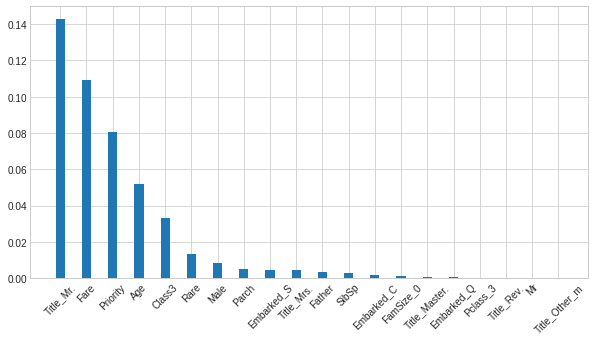

Title_Mr., Fare, Priority, Age, Class3, Rare, Male, Parch, Embarked_S, Title_Mrs., Father, SibSp, Embarked_C, FamSize_0, Title_Master., Embarked_Q, Pclass_3, Title_Rev., Mr, Title_Other_m
10-fold CV mean roc_auc: 0.8014030501089324%
Running time: 0:00:00.102114

GradientBoostingClassifier
10-fold CV mean roc_auc: 0.8981558158616982%
Running time: 0:00:15.681678

AdaBoost
10-fold CV mean roc_auc: 0.8763913363325129%
Running time: 0:00:25.652491

RandomForestClassifier
10-fold CV mean roc_auc: 0.8849144950909655%
Running time: 0:00:22.026546

ExtraTreesClassifier
10-fold CV mean roc_auc: 0.8755158588687999%
Running time: 0:00:10.166877

XGBClassifier
10-fold CV mean roc_auc: 0.9058776278188043%
Running time: 0:00:20.257840



In [99]:
for clf_name, clf in classifiers:
    print(clf_name)
    fit_evaluate(clf, X_train[:, rfecv.get_support()], y_train.values.astype('float'), feat_names)
    print()

We can see that gradient boosting, xgboost and catboost perform best. Logistic regression works surprisingly well, too. Wy may use those in our final model. But first, let's try ensembling.

### Ensembling

In [ ]:
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

    for i, (train_index, test_index) in enumerate(kf):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)


lr = SklearnHelper(LogisticRegression, feat_names, lr_params)
rf = SklearnHelper(RandomForestClassifier, feat_names, rf_params)
et = SklearnHelper(ExtraTreesClassifier, feat_names, et_params)
ada = SklearnHelper(AdaBoostClassifier, feat_names, ada_params)
gb = SklearnHelper(GradientBoostingClassifier, feat_names, gb_params)

lr_oof_train, lr_oof_test = get_oof(lr, X_train, y_train, X_test) 
rf_oof_train, rf_oof_test = get_oof(rf, X_train, y_train, X_test) 
et_oof_train, et_oof_test = get_oof(etf, X_train, y_train, X_test) 
ada_oof_train, ada_oof_test = get_oof(ada, X_train, y_train, X_test) 
gb_oof_train, gb_oof_test = get_oof(gb, X_train, y_train, X_test) 

### Grid search

In [ ]:
estim = GradientBoostingClassifier(gb_params)
pca = PCA(k=10)
rfecv = RFECV(estim)
pipeline = Pipeline(('PCA', pca), ('RFECV', rfecv))
param_grid = {}
grid_search = GridSearchCV(pipeline, param_grid=param_grid)